# TM10007 Assignment template -- ECG data

### Importing modules

In [86]:

! pip install sklearn numpy matplotlib imbalanced-learn statsmodels

import os
import zipfile
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns
import warnings
import statistics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

from sklearn.compose import TransformedTargetRegressor
from scipy.stats import shapiro, lognorm, randint
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve, GridSearchCV, StratifiedKFold, cross_val_score, KFold, train_test_split, RandomizedSearchCV, validation_curve #, multipletests
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn import datasets as ds, model_selection, metrics, neighbors
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multitest import multipletests
from sklearn.exceptions import ConvergenceWarning

# Classifiers
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


## Preprocessing

### Importing our data

In [87]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

### Exploring our data

In [88]:
# split labels from data
X = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

X = X.iloc[:50, :1000]
y = y.iloc[:50]

print(X.shape)
print(y.shape)

# normal / abnormal ECGs
total_abnormal_ECG = np.count_nonzero(y) 
total_normal_ECG = y.size -np.count_nonzero(y) 
percentage_abnormal = total_abnormal_ECG / (total_abnormal_ECG + total_normal_ECG)*100

print(f'{total_abnormal_ECG} people have an abnormal ECG')
print(f'{total_normal_ECG} people have a normal ECG')
print(f'The percentage of abnormal ECGs in this dataset is {percentage_abnormal} %')

(50, 1000)
(50,)
9 people have an abnormal ECG
41 people have a normal ECG
The percentage of abnormal ECGs in this dataset is 18.0 %


### Missing data
- Removing features if there is lot of data missing (replace all for a value)
- Removing samples (in this case patients) if there is a lot of data missing
- Imputation for generating data to fill us missing values -> median

In [89]:
def missing_data(X_design):
    # Missing data
    X_design = X_design.replace(0, np.nan)  # make all zeros to NaN
    nan_count = X_design.isna().sum().sum()  # count missing data -> 10500 in our dataset

    # Delete missing data when > --% of feature of sample is missing
    X_design = X_design.dropna(axis='columns', how='all') # deletes a feature if all values of a column (so feature) are empty
    X_design = X_design.dropna(axis='rows', how='all') # deletes a patient if all values of a row (so sample) are empty

    # Missing data to median per feature
    for column in X_design.columns:
        X_design[column].fillna(X_design[column].median(), inplace=True)
    return X_design

### Outliers
- Detect outliers using Z-score since data is not nornally distributed
- Replace outliers by the median of that feature
- Print -> check wether the outliers are changed

In [90]:
def removing_outliers(X_design):
    # supress performance warning
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

    # Outliers: Tukey's fence 
    k=3
    fences=pd.DataFrame()
    outliers = pd.DataFrame(False, index=X_design.index, columns=X_design.columns) # create an empty DataFrame for outliers

    for col in X_design.columns:
        q1, q3 = np.percentile(X_design[col], [25, 75])
        iqr = q3 - q1
        lower_fence = q1 - k*iqr
        upper_fence = q3 + k*iqr
        fences[col]=[lower_fence, upper_fence]
        for row in X_design.index:
            if X_design.loc[row, col] < lower_fence or X_design.loc[row, col] > upper_fence:
                outliers.loc[row, col] = True # mark the place as an outlier

    row_count = (outliers == True).sum(axis=1)
    col_count = (outliers == True).sum(axis=0)
    total_count = row_count.sum() + col_count.sum()
    print(f'The total number of outliers in dataset x is {total_count}')

    # create a copy of x to modify
    new_x = X_design.copy()

    #replace outliers with maximum or minimun interquartile range of x by column
    for col in outliers.columns:
        q3 = X_design.loc[outliers[col] == False, col].quantile(0.75) # 3rd quartile of column where outlier is False
        q1 = X_design.loc[outliers[col] == False, col].quantile(0.25) # 1st quartile of column where outlier is False
        iqr = q3 - q1 # interquartile range of column where outlier is False
        lower_fence = q1 - k*iqr
        upper_fence = q3 + k*iqr
        new_x.loc[outliers[col] & (new_x[col] > upper_fence), col] = upper_fence # replace outliers with upper fence
        new_x.loc[outliers[col] & (new_x[col] < lower_fence), col] = lower_fence # replace outliers with lower fence

        X_design = new_x.copy()
    return X_design

### PIPELINE 1
- RobustScaler --> PCA + univariate --> Gaussian Naive Bayes

In [91]:
# # Confusion matrix
# cm_all = None

# for i in range(len(y_pred_1_all)):

#     cm_i = confusion_matrix(y_test_1_all[i], y_pred_1_all[i])

#     if cm_all is None:
#         cm_all = cm_i
#     else:
#         cm_all += cm_i

# # Plot the confusion matrix as a heatmap
# sns.heatmap(cm_all, annot=True, cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion matrix Pipeline 1')
# plt.show()

In [92]:
# # Loop over rows and compute ROC curve and AUC for each row
# for i in range(len(y_pred_1_all)):
#     precision, recall, thresholds = precision_recall_curve(y_test_1_all[i], y_pred_1_all[i])
#     auc = average_precision_score(y_test_1_all[i], y_pred_1_all[i])

#     # Plot the ROC curve for each row
#     plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-recall curve for all rows')
# plt.legend(loc="lower right", fontsize=8)
# plt.show()


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Size_X_design (45, 1000)
[[0, 0, 0, 0, 0]]
Size X_test (5, 1000)
The total number of outliers in dataset x is 1862
The total number of outliers in dataset x is 426
shape after balancing (72, 1000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is"

   pca__n_components
0                0.5
shape of X_design after pca (72, 2)
size of features selected(2,)
after feature selection: (72, 2)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_design (45, 1000)
[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0]]
Size X_test (5, 1000)
The total number of outliers in dataset x is 1770
The total number of outliers in dataset x is 442
shape after balancing (74, 1000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
shape of X_design after pca (74, 3)
size of features selected(1,)
after feature selection: (74, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_design (45, 1000)
[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0]]
Size X_test (5, 1000)
The total number of outliers in dataset x is 1802
The total number of outliers in dataset x is 422
shape after balancing (74, 1000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
shape of X_design after pca (74, 2)
size of features selected(1,)
after feature selection: (74, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_design (45, 1000)
[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0]]
Size X_test (5, 1000)
The total number of outliers in dataset x is 1742
The total number of outliers in dataset x is 348
shape after balancing (74, 1000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
shape of X_design after pca (74, 2)
size of features selected(2,)
after feature selection: (74, 2)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_design (45, 1000)
[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0]]
Size X_test (5, 1000)
The total number of outliers in dataset x is 1740
The total number of outliers in dataset x is 394
shape after balancing (74, 1000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
shape of X_design after pca (74, 2)
size of features selected(2,)
after feature selection: (74, 2)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_design (45, 1000)
[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0]]
Size X_test (5, 1000)
The total number of outliers in dataset x is 1918
The total number of outliers in dataset x is 368
shape after balancing (74, 1000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
shape of X_design after pca (74, 2)
size of features selected(2,)
after feature selection: (74, 2)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_design (45, 1000)
[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0]]
Size X_test (5, 1000)
The total number of outliers in dataset x is 1516
The total number of outliers in dataset x is 848
shape after balancing (74, 1000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
shape of X_design after pca (74, 3)
size of features selected(1,)
after feature selection: (74, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_design (45, 1000)
[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0]]
Size X_test (5, 1000)
The total number of outliers in dataset x is 1734
The total number of outliers in dataset x is 370
shape after balancing (74, 1000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
7                0.5
shape of X_design after pca (74, 1)
size of features selected(1,)
after feature selection: (74, 1)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_design (45, 1000)
[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0]]
Size X_test (5, 1000)
The total number of outliers in dataset x is 1068
The total number of outliers in dataset x is 430
shape after balancing (74, 1000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
7                0.5
8                0.5
shape of X_design after pca (74, 3)
size of features selected(2,)
after feature selection: (74, 2)


C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_design (45, 1000)
[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0]]
Size X_test (5, 1000)
The total number of outliers in dataset x is 1930
The total number of outliers in dataset x is 334
shape after balancing (74, 1000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
4                0.5
5                0.5
6                0.5
7                0.5
8                0.5
9                0.5
shape of X_design after pca (74, 2)
size of features selected(2,)
after feature selection: (74, 2)
Mean and std of F1 scores of pipeline 1: 0.18333333333333332 +/- 0.2986595567936802
The optimal hyperparameters per split:    clf__var_smoothing
0        1.519911e-02
1        4.328761e-09
2        1.000000e-09
3        4.328761e-08
4        2.310130e-07
5        3.511192e-01
6        8.111308e-06
7        3.511192e-08
8        8.111308e-03
9        1.873817e-02
The best pipes per split [Pipeline(steps=[('clf', GaussianNB(var_smoothing=0.01519911082952933))]), Pipeline(steps=[('clf', GaussianNB(var_smoothing=4.328761281083061e-09))]), Pipeline(steps=[('clf', GaussianNB())]), Pipeline(steps=[('clf', GaussianNB(var_smoothing=4.3287612810830526e-08))]), Pipeline(st

C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_22324\3507893683.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


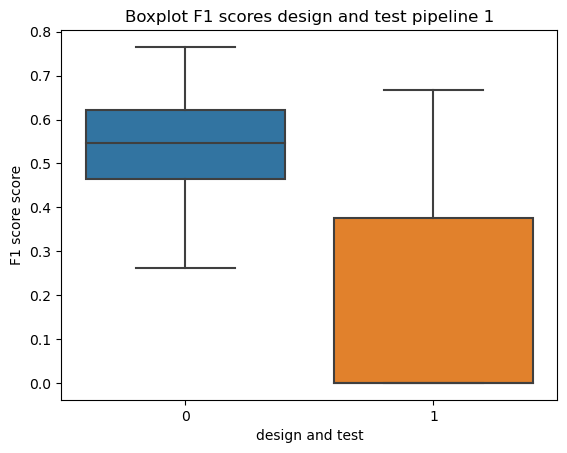

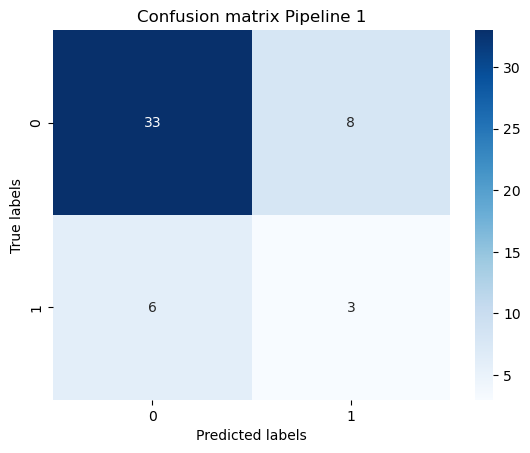

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


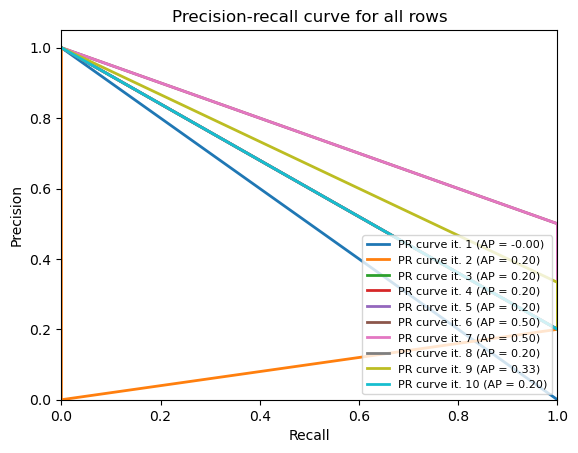

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.25      0.50      0.33         2
           2       0.50      0.33      0.40         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0

   micro avg       0.27      0.33      0.30         9
   macro avg       0.25      0.37      0.28         9
weighted avg       0.28      0.33      0.28         9
 samples avg       0.13      0.30      0.18         9



c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
# PIPELINE 1
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) 

f1_design_1_before = []
f1_test_1_before = []

f1_design_1_after = []
f1_test_1_after = []

results_1 = pd.DataFrame()
best_pipe_1 = []
best_hp_1_before = pd.DataFrame()
best_hp_1 = pd.DataFrame()

y_test_1_all = []
y_pred_1_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_1 = y[test_index].tolist()
    y_test_1_all.append(y_test_1)
    # y_test_1 = y[test_index]
    # y_test_1_all.append(y_test_1)
    #y_test_1_all.append(y_test_1.tolist())
    print(y_test_1_all)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')

    ## PIPELINE 1: RobustScaler --> PCA + univariate --> Gaussian Naive Bayes
    
    # Define pipeline 1
    pipeline_1a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA(n_components=0.5)),
    ])

    param_grid_1a = {
        'pca__n_components': [0.5],#,0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_1a = RandomizedSearchCV(pipeline_1a, param_distributions=param_grid_1a, n_iter=10, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    rand_search_1a.fit(X_design, y_design) # klopt dit fit_transform?
    X_design = rand_search_1a.best_estimator_.transform(X_design)
    X_test = rand_search_1a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_1_before = best_hp_1_before.append(rand_search_1a.best_params_,ignore_index=True)
    print(best_hp_1_before)
    print(f'shape of X_design after pca {X_design.shape}')

    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_design, y_design)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_design = X_design[:,features_selected]
    X_test = X_test[:,features_selected]
    
    # pipeline 1b
    pipeline_1b = Pipeline([
        ('clf', GaussianNB())
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_1b.fit(X_design, y_design)
 
    y_pred_design_1 = pipeline_1b.predict(X_design)
    f1_design_1_bef = f1_score(y_design, y_pred_design_1)
    f1_design_1_before.append(f1_design_1_bef)

    y_pred_test_1_before = pipeline_1b.predict(X_test)
    f1_test_1_bef = f1_score(y_test_1, y_pred_test_1_before)
    f1_test_1_before.append(f1_test_1_bef)

    # Define hyperparameters of pipeline 1
    param_grid_1b = {
    'clf__var_smoothing': np.logspace(0,-9, num=100),
    }

    print(f'after feature selection: {X_design.shape}')

    # Perform grid search with inner cross-validation, part 2
    model_1 = RandomizedSearchCV(pipeline_1b, param_distributions=param_grid_1b, n_iter=50, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    model_1.fit(X_design, y_design)
    results = pd.DataFrame(model_1.cv_results_)
    results_1 = results_1.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    y_pred_design_1_after = model_1.predict(X_design)
    f1_design_1_aft = f1_score(y_design, y_pred_design_1_after)
    f1_design_1_after.append(f1_design_1_aft)
    
    y_pred_test_1_after = model_1.predict(X_test)
    y_pred_1_all.append(y_pred_test_1_after)
    
    f1_test_1_aft = f1_score(y_test_1, y_pred_test_1_after)
    f1_test_1_after.append(f1_test_1_aft)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_1.append(model_1.best_estimator_)

# Save results of inner CV into .csv file
results_1.to_csv('results_1.csv', index=False)

print(f'Mean and std of F1 scores of pipeline 1: {statistics.mean(f1_test_1_after)} +/- {statistics.stdev(f1_test_1_after)}')

print(f'The optimal hyperparameters per split: {best_hp_1}')
print(f'The best pipes per split {best_pipe_1}')

print(f'The design F1 scores before tuning {f1_design_1_before}')
print(f'The test F1 scores before tuning {f1_test_1_before}')

print(f'The design F1 scores after tuning {f1_design_1_after}')
print(f'The test F1 scores afer tuning {f1_test_1_after}')


data_1 = [f1_design_1_after, f1_test_1_after]
sns.boxplot(data=data_1)
plt.title('Boxplot F1 scores design and test pipeline 1')
plt.xlabel('design and test')
plt.ylabel('F1 score score')
plt.show()

# # Confusion matrix
# threshold = 0.5
# cm_all = None

# for i in range(len(y_pred_1_all)):
#     y_pred_1_all_bin= np.array(y_pred_1_all[i])
#     y_pred_1_all_bin = np.where(y_pred_1_all_bin >= threshold, 1, 0)

#     cm_i = confusion_matrix(y_test_1_all[i], y_pred_1_all_bin)

#     if cm_all is None:
#         cm_all = cm_i
#     else:
#         cm_all += cm_i

# Confusion matrix
#cm_1 = confusion_matrix(y_test_1_all, y_pred_1_all)
# y_pred_1_all = [list(x) for x in y_pred_1_all]
#y_test_1_all = [arr.tolist() for arr in y_test_1_all]
# y_test_1_all = (y_test_1_all >= 0.5).astype(int)
# convert numpy arrays to Python lists
y_pred_1_all = [arr.tolist() for arr in y_pred_1_all]
y_test_1_all = np.array(y_test_1_all)
y_pred_1_all = np.array(y_pred_1_all)

cm_1 = confusion_matrix(y_test_1_all.ravel(), y_pred_1_all.ravel())



# Plot the confusion matrix as a heatmap
sns.heatmap(cm_1, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 1')
plt.show()

# Loop over rows and compute precision recall curve for each row
for i in range(len(y_pred_1_all)):
    precision, recall, thresholds = precision_recall_curve(y_test_1_all[i], y_pred_1_all[i])
    auc = average_precision_score(y_test_1_all[i], y_pred_1_all[i])

    # Plot the ROC curve for each row
    plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve for all rows')
plt.legend(loc="lower right", fontsize=8)
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test_1_all, y_pred_1_all))



Probeersel

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\metrics\_classif

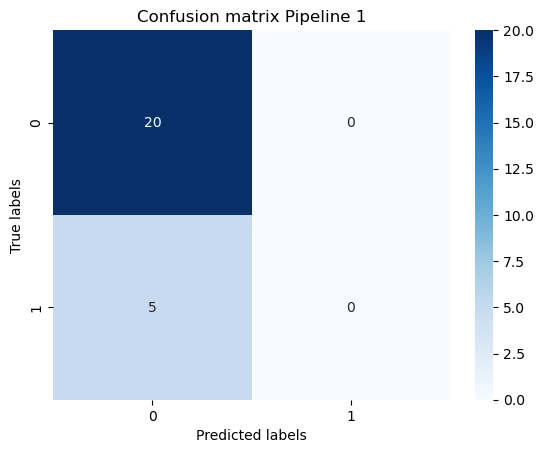

In [94]:
print(y_pred_1_all)
print(y_test_1_all)

from sklearn.metrics import classification_report
print(classification_report(y_test_1_all, y_pred_1_all))
#cm_1 = confusion_matrix(y_test_1_all, y_pred_1_all)
cm_1 = confusion_matrix(y_test_1, y_pred_test_1_after)
sns.heatmap(cm_1, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 1')
plt.show()




In [ ]:
from sklearn.metrics import confusion_matrix

threshold = 0.5
y_pred_test_1= np.array(y_pred_test_1)
y_pred_design_1 = (y_pred_test_1 >= threshold).astype(int)
cm1 = confusion_matrix(y_test_1, y_pred_design_1)

NameError: name 'y_pred_test_1' is not defined

In [ ]:
print(f'Mean and std ROC_AUC of pipeline 1: {statistics.mean(best_auc_test_1)} +/- {statistics.stdev(best_auc_test_1)}')


Mean and std ROC_AUC of pipeline 1: 0.6215147363293143 +/- 0.09219828843751172


In [ ]:
results_1

# Print the DataFrame to a CSV file
results_1.to_csv('results_1.csv', index=False)

The optimal hyperparameters per split:    clf__var_smoothing
0            0.123285
1            0.053367
2            0.351119
The best pipes per split [Pipeline(steps=[('clf', GaussianNB(var_smoothing=0.12328467394420659))]), Pipeline(steps=[('clf', GaussianNB(var_smoothing=0.0533669923120631))]), Pipeline(steps=[('clf', GaussianNB(var_smoothing=0.3511191734215131))])]
The designing AUCs before tuning [0.6339993067934244, 0.624534575296066, 0.6647074206443097]
The test AUCs before tuning [0.6573498964803313, 0.65, 0.5901960784313725]
The designing AUCs after tuning [0.6314740542681718, 0.6250575943613563, 0.660249305754455]
The test AUCs afer tuning [0.639751552795031, 0.6441176470588235, 0.5607843137254902]


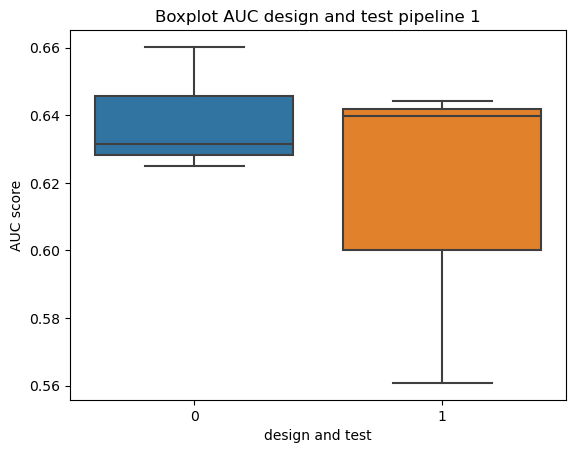

In [ ]:
print(f'The optimal hyperparameters per split: {best_hp_1}')
print(f'The best pipes per split {best_pipe_1}')

print(f'The design AUCs before tuning {auc_design_1}')
print(f'The test AUCs before tuning {auc_test_1}')

print(f'The design AUCs after tuning {best_auc_design_1}')
print(f'The test AUCs afer tuning {best_auc_test_1}')

data_1 = [best_auc_design_1, best_auc_test_1]
sns.boxplot(data=data_1)
plt.title('Boxplot AUC design and test pipeline 1')
plt.xlabel('design and test')
plt.ylabel('AUC score')
plt.show()

In [ ]:
results_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002993,1.857333e-06,0.003990,3.769729e-07,0.000003,{'clf__var_smoothing': 2.848035868435799e-06},0.576550,0.654387,0.665874,0.613785,0.627649,0.035283,2
1,0.002494,4.991294e-04,0.003740,4.319146e-04,0.000066,{'clf__var_smoothing': 6.579332246575683e-05},0.576550,0.654387,0.665874,0.613785,0.627649,0.035283,2
2,0.002243,4.299895e-04,0.003491,4.970440e-04,0.000002,{'clf__var_smoothing': 2.310129700083158e-06},0.576550,0.654387,0.665874,0.613785,0.627649,0.035283,2
3,0.001994,7.055393e-04,0.003491,4.987719e-04,0.0,{'clf__var_smoothing': 1.519911082952933e-07},0.576550,0.654387,0.665874,0.613785,0.627649,0.035283,2
4,0.002494,4.988315e-04,0.003241,4.321900e-04,0.0,{'clf__var_smoothing': 6.579332246575682e-08},0.576550,0.654387,0.665874,0.613785,0.627649,0.035283,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.001994,7.055390e-04,0.002743,4.315021e-04,0.000008,{'clf__var_smoothing': 8.111308307896873e-06},0.695211,0.638344,0.600317,0.646069,0.644985,0.033776,10
146,0.001745,4.317085e-04,0.001995,5.930587e-07,0.0,{'clf__var_smoothing': 4.328761281083061e-09},0.695211,0.638344,0.600317,0.646069,0.644985,0.033776,10
147,0.001745,4.320523e-04,0.002743,4.321900e-04,0.0,{'clf__var_smoothing': 2.848035868435805e-09},0.695211,0.638344,0.600317,0.646069,0.644985,0.033776,10
148,0.001995,8.492355e-07,0.001995,8.760058e-07,0.0,{'clf__var_smoothing': 1e-08},0.695211,0.638344,0.600317,0.646069,0.644985,0.033776,10


### PIPELINE 2
- PCA-Uni --> Quadratic Discriminant Analysis

Size_X_train (37, 1000)
Size X_test (13, 1000)
The total number of outliers in dataset x is 1716
The total number of outliers in dataset x is 374
shape after balancing (60, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2757982181.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2a = best_hp_2a.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
shape of X_train after pca (60, 1)
size of features selected(1,)
Size_X_train (37, 1000)
Size X_test (13, 1000)
The total number of outliers in dataset x is 1540
The total number of outliers in dataset x is 404
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2757982181.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2a = best_hp_2a.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
shape of X_train after pca (62, 2)
size of features selected(1,)
Size_X_train (38, 1000)
Size X_test (12, 1000)
The total number of outliers in dataset x is 1442
The total number of outliers in dataset x is 630
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2757982181.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2a = best_hp_2a.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
shape of X_train after pca (62, 3)
size of features selected(1,)
Size_X_train (38, 1000)
Size X_test (12, 1000)
The total number of outliers in dataset x is 1080
The total number of outliers in dataset x is 694
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2757982181.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2a = best_hp_2a.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
shape of X_train after pca (62, 3)
size of features selected(2,)
The optimal hyperparameters per split:    pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
The training AUCs after QDA [0.7144444444444444, 0.8158168574401664, 0.7263267429760665, 0.7825182101977107]
The test AUCs afer QDA [0.7727272727272727, 0.6666666666666666, 0.5, 0.9]


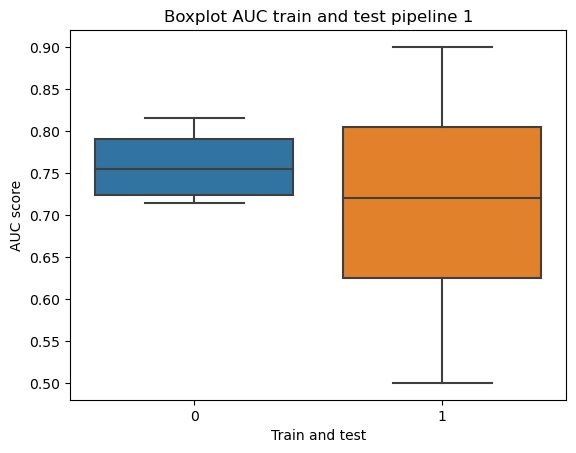

In [ ]:
# PIPELINE 2
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

best_auc_design_2 = []
best_auc_test_2 = []

best_hp_2a = pd.DataFrame()

y_test_2_all = []
y_pred_2_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_2 = y[test_index]
    y_test_2_all.append(y_test_2)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')

    ## PIPELINE 2: QDA
    
    # Define pipeline 2
    pipeline_2a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
    ])

    param_grid_2a = {
        'pca__n_components': [0.5],#0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_2a = RandomizedSearchCV(pipeline_2a, param_distributions=param_grid_2a, n_iter=10, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    rand_search_2a.fit(X_design, y_design) # klopt dit fit_transform?
    X_design = rand_search_2a.best_estimator_.transform(X_design)
    X_test = rand_search_2a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_2a = best_hp_2a.append(rand_search_2a.best_params_,ignore_index=True)
    print(best_hp_2a)
    print(f'shape of X_design after pca {X_design.shape}')

    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_design, y_design)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_design = X_design[:,features_selected]
    X_test = X_test[:,features_selected]

    # design the classifier on the selected features with the best hyperparameters to create best designed classifier
    model_2 = QuadraticDiscriminantAnalysis()
    model_2.fit(X_design, y_design)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_design_2 = model_2.predict_proba(X_design)[:,1]
    best_f1_score_design_2 = f1_score(y_design, best_y_pred_design_2)

    best_y_pred_test_2 = model_2.predict_proba(X_test)[:,1]
    best_f1_score_test_2 = f1_score(y_test_2, best_y_pred_test_2)

    best_auc_design_2.append(best_f1_score_design_2)
    best_auc_test_2.append(best_f1_score_test_2)

print(f'The optimal hyperparameters per split: {best_hp_2a}')

print(f'The design AUCs after QDA {best_auc_design_2}')
print(f'The test AUCs afer QDA {best_auc_test_2}')

data_2 = [best_auc_design_2, best_auc_test_2]
sns.boxplot(data=data_2)
plt.title('Boxplot AUC design and test pipeline 1')
plt.xlabel('design and test')
plt.ylabel('AUC score')
plt.show()


### PIPELINE 3
- RobustScaler --> PCA + univariate --> SVM_linear

Size_X_train (37, 1000)
Size X_test (13, 1000)
The total number of outliers in dataset x is 1716
The total number of outliers in dataset x is 374
shape after balancing (60, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3a = best_hp_3a.append(rand_search_3a.best_params_,ignore_index=True)


shape of X_train after pca (60, 2)
size of features selected(2,)
shape of X_train after univariate: (60, 2)
Size_X_train (37, 1000)
Size X_test (13, 1000)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_3 = results_3.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)


The total number of outliers in dataset x is 1540
The total number of outliers in dataset x is 404
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3a = best_hp_3a.append(rand_search_3a.best_params_,ignore_index=True)


shape of X_train after pca (62, 2)
size of features selected(2,)
shape of X_train after univariate: (62, 2)
Size_X_train (38, 1000)
Size X_test (12, 1000)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_3 = results_3.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)


The total number of outliers in dataset x is 1442
The total number of outliers in dataset x is 630
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3a = best_hp_3a.append(rand_search_3a.best_params_,ignore_index=True)


shape of X_train after pca (62, 3)
size of features selected(1,)
shape of X_train after univariate: (62, 1)
Size_X_train (38, 1000)
Size X_test (12, 1000)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_3 = results_3.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)


The total number of outliers in dataset x is 1080
The total number of outliers in dataset x is 694
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3a = best_hp_3a.append(rand_search_3a.best_params_,ignore_index=True)


shape of X_train after pca (62, 3)
size of features selected(2,)
shape of X_train after univariate: (62, 2)
The optimal hyperparameters per split:    pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
The optimal hyperparameters per split:      clf__C
0  0.006952
1  0.001000
2  1.438450
3  0.002637
The best pipes per split [Pipeline(steps=[('clf', SVC(C=0.0069519279617756054, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=0.001, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=1.438449888287663, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=0.0026366508987303583, kernel='linear'))])]
The training AUCs before tuning [0.8022222222222223, 0.8782518210197711, 0.6826222684703434, 0.822060353798127]
The test AUCs before tuning [0.6363636363636364, 0.6333333333333333, 0.55, 0.9]
The training AUCs after tuning [0.8022222222222223, 0.8407908428720083, 0.6826222684703434, 0.8210197710718001]
The test AUCs afer tuning [0.63636363636363

C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_3 = results_3.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\2643325771.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)


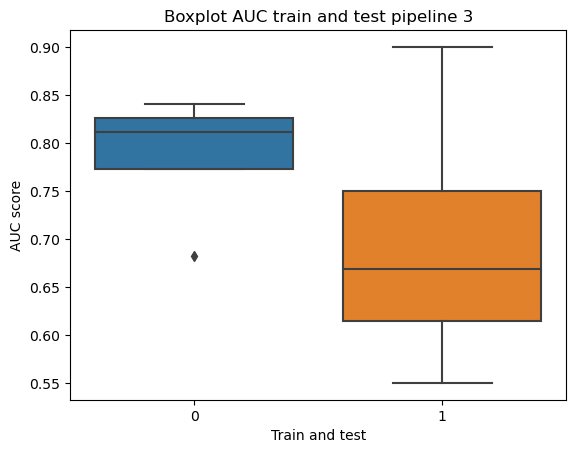

In [ ]:
# PIPELINE 3
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

auc_design_3 = []
auc_test_3 = []

best_auc_design_3 = []
best_auc_test_3 = []

results_3 = pd.DataFrame()
best_pipe_3 = []
best_hp_3a = pd.DataFrame()
best_hp_3 = pd.DataFrame()

y_test_3_all = []
y_pred_3_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_3 = y[test_index]
    y_test_3_all.append(y_test_3)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')

    ## PIPELINE 3: RobustScaler --> PCA + univariate --> linear SVM
    
    # Define pipeline 3
    pipeline_3a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
    ])

    param_grid_3a = {
        'pca__n_components': [0.5],#0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_3a = RandomizedSearchCV(pipeline_3a, param_distributions=param_grid_3a, n_iter=10, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    rand_search_3a.fit(X_design, y_design) # klopt dit fit_transform?
    X_design = rand_search_3a.best_estimator_.transform(X_design)
    X_test = rand_search_3a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_3a = best_hp_3a.append(rand_search_3a.best_params_,ignore_index=True)
    print(f'shape of X_design after pca {X_design.shape}')

    # univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_design, y_design)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_design = X_design[:,features_selected]
    X_test = X_test[:,features_selected]
        
    print(f'shape of X_design after univariate: {X_design.shape}')
    
    # pipeline 3b
    pipeline_3b = Pipeline([    
        ('clf', SVC(kernel='linear'))
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_3b.fit(X_design, y_design)
 
    y_pred_design_3 = pipeline_3b.decision_function(X_design)
    f1_design_3 = f1_score(y_design, y_pred_design_3)

    y_pred_test_3 = pipeline_3b.decision_function(X_test)
    f1_test_3 = f1_score(y_test_3, y_pred_test_3)

    auc_design_3.append(f1_design_3)
    auc_test_3.append(f1_test_3)
    
    # Define hyperparameters of pipeline 3
    param_grid_3b = {
    'clf__C': np.logspace(-3, 1, 20),
    }

    # Perform grid search with inner cross-validation, part 1
    model_3 = RandomizedSearchCV(pipeline_3b, param_distributions=param_grid_3b, cv=inner_cv, scoring='f1', n_iter=50, n_jobs=-1) # optimize parameters
    model_3.fit(X_design, y_design)

    results = pd.DataFrame(model_3.cv_results_)
    results_3 = results_3.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_design_3 = model_3.decision_function(X_design)
    best_f1_score_design_3 = f1_score(y_design, best_y_pred_design_3)

    best_y_pred_test_3 = model_3.decision_function(X_test)
    best_f1_score_test_3 = f1_score(y_test_3, best_y_pred_test_3)

    best_auc_design_3.append(best_f1_score_design_3)
    best_auc_test_3.append(best_f1_score_test_3)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_3.append(model_3.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_3a}')
print(f'The optimal hyperparameters per split: {best_hp_3}')
print(f'The best pipes per split {best_pipe_3}')

print(f'The design AUCs before tuning {auc_design_3}')
print(f'The test AUCs before tuning {auc_test_3}')

print(f'The design AUCs after tuning {best_auc_design_3}')
print(f'The test AUCs afer tuning {best_auc_test_3}')

data_3 = [best_auc_design_3, best_auc_test_3]
sns.boxplot(data=data_3)
plt.title('Boxplot AUC design and test pipeline 3')
plt.xlabel('design and test')
plt.ylabel('AUC score')
plt.show()


### PIPELINE 4
- PCA-UNI --> KNN

Size_X_train (37, 1000)
Size X_test (13, 1000)
The total number of outliers in dataset x is 1716
The total number of outliers in dataset x is 374
shape after balancing (60, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4a = best_hp_4a.append(rand_search_4a.best_params_,ignore_index=True)


shape of X_train after pca (60, 2)
size of features selected(1,)
shape of X_train after univariate: (60, 1)
Size_X_train (37, 1000)
Size X_test (13, 1000)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_4 = results_4.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4 = best_hp_4.append(model_4.best_params_,ignore_index=True)


The total number of outliers in dataset x is 1540
The total number of outliers in dataset x is 404
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4a = best_hp_4a.append(rand_search_4a.best_params_,ignore_index=True)


shape of X_train after pca (62, 2)
size of features selected(2,)
shape of X_train after univariate: (62, 2)
Size_X_train (38, 1000)
Size X_test (12, 1000)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_4 = results_4.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4 = best_hp_4.append(model_4.best_params_,ignore_index=True)


The total number of outliers in dataset x is 1442
The total number of outliers in dataset x is 630
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4a = best_hp_4a.append(rand_search_4a.best_params_,ignore_index=True)


shape of X_train after pca (62, 2)
size of features selected(2,)
shape of X_train after univariate: (62, 2)
Size_X_train (38, 1000)
Size X_test (12, 1000)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_4 = results_4.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4 = best_hp_4.append(model_4.best_params_,ignore_index=True)


The total number of outliers in dataset x is 1080
The total number of outliers in dataset x is 694
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4a = best_hp_4a.append(rand_search_4a.best_params_,ignore_index=True)


shape of X_train after pca (62, 3)
size of features selected(2,)
shape of X_train after univariate: (62, 2)
The optimal hyperparameters per split:    pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
The optimal hyperparameters per split:    clf__p  clf__n_neighbors  clf__leaf_size
0       1                 8              19
1       2                14               1
2       1                 4               1
3       1                 4               3
The best pipes per split [Pipeline(steps=[('clf',
                 KNeighborsClassifier(leaf_size=19, n_neighbors=8, p=1))]), Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=1, n_neighbors=14))]), Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=1, n_neighbors=4, p=1))]), Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=3, n_neighbors=4, p=1))])]
The training AUCs before tuning [0.9750000000000001, 0.9937565036420395, 0.9469302809573361, 0.9828303850156087]
The test

C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_4 = results_4.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\4264658525.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4 = best_hp_4.append(model_4.best_params_,ignore_index=True)


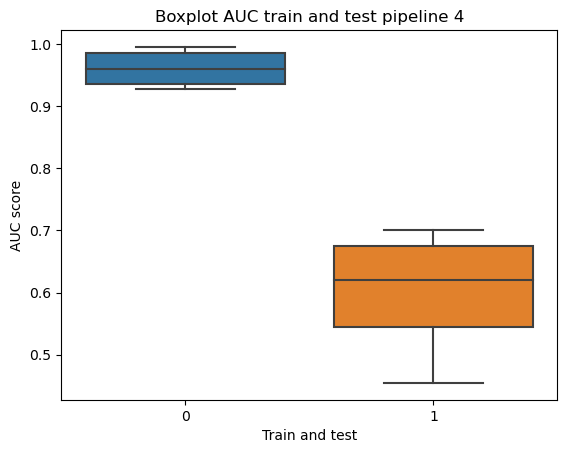

In [ ]:
# PIPELINE 4
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

auc_design_4 = []
auc_test_4 = []

best_auc_design_4 = []
best_auc_test_4 = []

results_4 = pd.DataFrame()
best_pipe_4 = []
best_hp_4a = pd.DataFrame()
best_hp_4 = pd.DataFrame()

y_test_4_all = []
y_pred_4_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_4 = y[test_index]
    y_test_4_all.append(y_test_4)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')

    ## PIPELINE 4: RobustScaler --> PCA + univariate --> KNN
    
    # Define pipeline 4a
    pipeline_4a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
    ])

    param_grid_4a = {
        'pca__n_components': [0.5],#0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_4a = RandomizedSearchCV(pipeline_4a, param_distributions=param_grid_4a, n_iter=10, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    rand_search_4a.fit(X_design, y_design) # klopt dit fit_transform?
    X_design = rand_search_4a.best_estimator_.transform(X_design)
    X_test = rand_search_4a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_4a = best_hp_4a.append(rand_search_4a.best_params_,ignore_index=True)
    print(f'shape of X_design after pca {X_design.shape}')

    # univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_design, y_design)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_design = X_design[:,features_selected]
    X_test = X_test[:,features_selected]
        
    print(f'shape of X_design after univariate: {X_design.shape}')
    
    # pipeline 4b
    pipeline_4b = Pipeline([    
        ('clf', KNeighborsClassifier())
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_4b.fit(X_design, y_design)
 
    y_pred_design_4 = pipeline_4b.predict_proba(X_design)[:,1]
    f1_design_4 = f1_score(y_design, y_pred_design_4)

    y_pred_test_4 = pipeline_4b.predict_proba(X_test)[:,1]
    f1_test_4 = f1_score(y_test_4, y_pred_test_4)

    auc_design_4.append(f1_design_4)
    auc_test_4.append(f1_test_4)
    
    # Define hyperparameters of pipeline 4
    param_grid_4b = {
    'clf__n_neighbors': list(range(4,26,2)), # op 4 begonnen, want uit learning curves bleek dat vanaf 5 goede fit en lager slechte fit
    'clf__p': [1,2],
    'clf__leaf_size': np.arange(1,26,1)
    }

    # Perform grid search with inner cross-validation, part 1
    model_4 = RandomizedSearchCV(pipeline_4b, param_distributions=param_grid_4b, cv=inner_cv, scoring='f1', n_iter= 50, n_jobs=-1) # optimize parameters
    model_4.fit(X_design, y_design)

    results = pd.DataFrame(model_4.cv_results_)
    results_4 = results_4.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_design_4 = model_4.predict_proba(X_design)[:,1]
    best_f1_score_design_4 = f1_score(y_design, best_y_pred_design_4)

    best_y_pred_test_4 = model_4.predict_proba(X_test)[:,1]
    best_f1_score_test_4 = f1_score(y_test_4, best_y_pred_test_4)

    best_auc_design_4.append(best_f1_score_design_4)
    best_auc_test_4.append(best_f1_score_test_4)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_4 = best_hp_4.append(model_4.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_4.append(model_4.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_4a}')
print(f'The optimal hyperparameters per split: {best_hp_4}')
print(f'The best pipes per split {best_pipe_4}')

print(f'The design AUCs before tuning {auc_design_4}')
print(f'The test AUCs before tuning {auc_test_4}')

print(f'The design AUCs after tuning {best_auc_design_4}')
print(f'The test AUCs afer tuning {best_auc_test_4}')

data_4 = [best_auc_design_4, best_auc_test_4]
sns.boxplot(data=data_4)
plt.title('Boxplot AUC design and test pipeline 4')
plt.xlabel('design and test')
plt.ylabel('AUC score')
plt.show()


### PIPELINE 5 
- LASSO --> KNN

Size_X_train (37, 1000)
Size X_test (13, 1000)
The total number of outliers in dataset x is 1716
The total number of outliers in dataset x is 374
shape after balancing (60, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e-02, tolerance: 1.500e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e-02, tolerance: 1.500e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5a = best_hp_5a.append(rand_search_5a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (60, 59)
This is the size of X_train after LASSO: (60, 59)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


Size_X_train (37, 1000)
Size X_test (13, 1000)
The total number of outliers in dataset x is 1540
The total number of outliers in dataset x is 404
shape after balancing (62, 1000)
This is the size of X_train after LASSO: (62, 33)
This is the size of X_train after LASSO: (62, 33)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5a = best_hp_5a.append(rand_search_5a.best_params_,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


Size_X_train (38, 1000)
Size X_test (12, 1000)
The total number of outliers in dataset x is 1442
The total number of outliers in dataset x is 630
shape after balancing (62, 1000)
This is the size of X_train after LASSO: (62, 8)
This is the size of X_train after LASSO: (62, 8)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5a = best_hp_5a.append(rand_search_5a.best_params_,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


Size_X_train (38, 1000)
Size X_test (12, 1000)
The total number of outliers in dataset x is 1080
The total number of outliers in dataset x is 694
shape after balancing (62, 1000)
This is the size of X_train after LASSO: (62, 30)
This is the size of X_train after LASSO: (62, 30)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5a = best_hp_5a.append(rand_search_5a.best_params_,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\236455054.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


The optimal hyperparameters per split:    lasso__alpha
0      0.000599
1      0.001668
2      0.166810
3      0.012915
The optimal hyperparameters per split:    clf__p  clf__n_neighbors  clf__leaf_size
0       1                 6               4
1       2                 8               9
2       2                22              18
3       1                10               9
The best pipes per split [Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=4, n_neighbors=6, p=1))]), Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=9, n_neighbors=8))]), Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=18, n_neighbors=22))]), Pipeline(steps=[('clf',
                 KNeighborsClassifier(leaf_size=9, n_neighbors=10, p=1))])]
The training AUCs before tuning [0.9938888888888888, 1.0, 0.9973985431841832, 0.9973985431841831]
The test AUCs before tuning [0.38636363636363635, 0.5666666666666667, 0.6749999999999999, 0.575]
The training AUCs after tuning [0.9855555555555555, 1.0, 0.9890

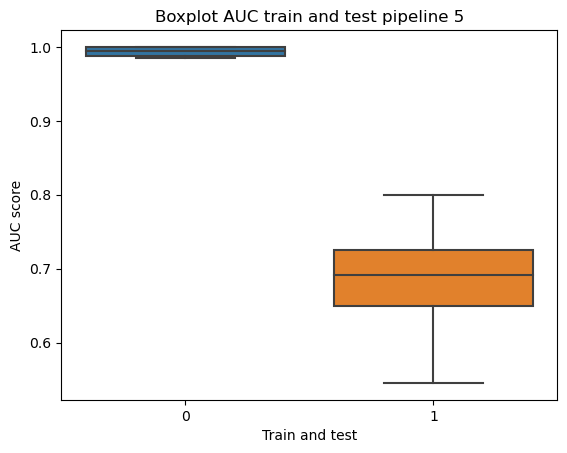

In [ ]:
# PIPELINE 5

# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

auc_design_5 = []
auc_test_5 = []

best_auc_design_5 = []
best_auc_test_5 = []

results_5 = pd.DataFrame()
best_pipe_5 = []
best_hp_5a = pd.DataFrame()
best_hp_5 = pd.DataFrame()

y_test_5_all = []
y_pred_5_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_5 = y[test_index]
    y_test_5_all.append(y_test_5)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')  

    # Scaling the data
    scaler = RobustScaler()
    X_design = scaler.fit_transform(X_design)
    X_test = scaler.transform(X_test)

    ## PIPELINE 5: RobustScaler --> LASSO --> KNN
    # Define pipeline 5
    pipeline_5a = Pipeline([
        ('lasso', Lasso()),
    ])
    # Define hyperparameters of pipeline 5
    param_grid_5a = {
    'lasso__alpha': np.logspace(-10, 1, 100),
    }

    # Perform randomized search with inner cross-validation to find best alpha
    rand_search_5a = RandomizedSearchCV(pipeline_5a, param_distributions=param_grid_5a, n_iter=50, cv=inner_cv, scoring='f1',n_jobs=-1) # optimize parameters
    rand_search_5a.fit(X_design, y_design)
    
    # Create a new Lasso model using the best alpha value
    lasso = Lasso(alpha=rand_search_5a.best_params_['lasso__alpha'])
    lasso.fit(X_design, y_design)

    # Get the coefficients of the Lasso model, find them and define the new X_design with less features
    coef = lasso.coef_
    selected_features = np.where(coef != 0)[0]
    X_design = X_design[:, selected_features]
    X_test = X_test[:, selected_features]
    print(f'This is the size of X_design after LASSO: {X_design.shape}')

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_5a = best_hp_5a.append(rand_search_5a.best_params_,ignore_index=True)
    
    print(f'This is the size of X_design after LASSO: {X_design.shape}')

## PIPELINE 5: RF
    # Define pipeline 5b
    pipeline_5b = Pipeline([
        ('clf', KNeighborsClassifier())
        ])
    
    # Define scores BEFORE hyperparameter tuning
    pipeline_5b.fit(X_design, y_design)
 
    y_pred_design_5 = pipeline_5b.predict_proba(X_design)[:,1]
    f1_design_5 = f1_score(y_design, y_pred_design_5)

    y_pred_test_5 = pipeline_5b.predict_proba(X_test)[:,1]
    f1_test_5 = f1_score(y_test_5, y_pred_test_5)

    auc_design_5.append(f1_design_5)
    auc_test_5.append(f1_test_5)

    # Define hyperparameters of pipeline 5b
    param_grid_5b = {'clf__n_neighbors': list(range(4,26,2)),
                  'clf__p': [1,2],
                  'clf__leaf_size': np.arange(1,26,1)
                }

    # Perform grid search with inner cross-validation, part 1
    model_5 = RandomizedSearchCV(pipeline_5b, param_distributions=param_grid_5b, n_iter=50, cv=inner_cv, scoring='f1', n_jobs=-1) # optimize parameters
    model_5.fit(X_design, y_design)

    # Storing results cross-validation
    results = pd.DataFrame(model_5.cv_results_)
    results_5 = results_5.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_design_5 = model_5.predict_proba(X_design)[:,1]
    best_f1_score_design_5 = f1_score(y_design, best_y_pred_design_5)

    best_y_pred_test_5 = model_5.predict_proba(X_test)[:,1]
    best_f1_score_test_5 = f1_score(y_test_5, best_y_pred_test_5)

    best_auc_design_5.append(best_f1_score_design_5)
    best_auc_test_5.append(best_f1_score_test_5)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_5.append(model_5.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_5a}')
print(f'The optimal hyperparameters per split: {best_hp_5}')
print(f'The best pipes per split {best_pipe_5}')

print(f'The design AUCs before tuning {auc_design_5}')
print(f'The test AUCs before tuning {auc_test_5}')

print(f'The design AUCs after tuning {best_auc_design_5}')
print(f'The test AUCs afer tuning {best_auc_test_5}')

data_5 = [best_auc_design_5, best_auc_test_5]
sns.boxplot(data=data_5)
plt.title('Boxplot AUC design and test pipeline 5')
plt.xlabel('design and test')
plt.ylabel('AUC score')
plt.show()     

# Plot ROC-AUC
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Loop over rows and compute ROC curve and AUC for each row
for i in range(y_pred_1_all.shape[0]):
    precision, recall, thresholds = precision_recall_curve(y_test_1_all[i], y_pred_1_all[i])
    auc = average_precision_score(y_test_1_all[i], y_pred_1_all[i])

    # Plot the ROC curve for each row
    plt.plot(recall, precision, lw=2, label='PR curve it. %d (AP = %0.2f)' % (i+1, auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve for all rows')
plt.legend(loc="lower right", fontsize=8)
plt.show()




### PIPELINE 6
- PCA-UNI --> Random Forest

Size_X_train (37, 1000)
Size X_test (13, 1000)
The total number of outliers in dataset x is 1716
The total number of outliers in dataset x is 374
shape after balancing (60, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6a = best_hp_6a.append(rand_search_6a.best_params_,ignore_index=True)


shape of X_train after pca (60, 2)
size of features selected(2,)
shape of X_train after univariate: (60, 2)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_6 = results_6.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)


Size_X_train (37, 1000)
Size X_test (13, 1000)
The total number of outliers in dataset x is 1540
The total number of outliers in dataset x is 404
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6a = best_hp_6a.append(rand_search_6a.best_params_,ignore_index=True)


shape of X_train after pca (62, 2)
size of features selected(2,)
shape of X_train after univariate: (62, 2)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_6 = results_6.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)


Size_X_train (38, 1000)
Size X_test (12, 1000)
The total number of outliers in dataset x is 1442
The total number of outliers in dataset x is 630
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6a = best_hp_6a.append(rand_search_6a.best_params_,ignore_index=True)


shape of X_train after pca (62, 1)
size of features selected(1,)
shape of X_train after univariate: (62, 1)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_6 = results_6.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)


Size_X_train (38, 1000)
Size X_test (12, 1000)
The total number of outliers in dataset x is 1080
The total number of outliers in dataset x is 694
shape after balancing (62, 1000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6a = best_hp_6a.append(rand_search_6a.best_params_,ignore_index=True)


shape of X_train after pca (62, 2)
size of features selected(2,)
shape of X_train after univariate: (62, 2)
The optimal hyperparameters per split:    pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
The optimal hyperparameters per split:    clf__warm_start  clf__n_estimators  clf__min_weight_fraction_leaf  \
0             True                 35                       0.229167   
1             True                495                       0.104167   
2            False                965                       0.000000   
3            False                175                       0.041667   

   clf__min_samples_split  clf__min_samples_leaf clf__max_features  \
0                       2                      6              sqrt   
1                       5                      2              sqrt   
2                       6                      3              log2   
3                       8                      2              None  

C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_6 = results_6.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1471524158.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)


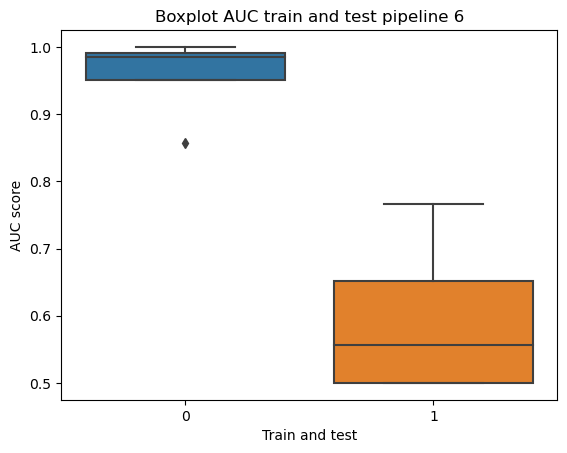

In [ ]:
# PIPELINE 6
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

auc_design_6 = []
auc_test_6 = []

best_auc_design_6 = []
best_auc_test_6 = []

results_6 = pd.DataFrame()
best_pipe_6 = []
best_hp_6a = pd.DataFrame()
best_hp_6 = pd.DataFrame()

y_test_6_all = []
y_pred_6_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_6 = y[test_index]
    y_test_6_all.append(y_test_6)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')

    ## PIPELINE 6: RobustScaler --> PCA + univariate --> RF
    
    # Define pipeline 6a
    pipeline_6a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
    ])

    param_grid_6a = {
        'pca__n_components': [0.5],#,0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_6a = RandomizedSearchCV(pipeline_6a, param_distributions=param_grid_6a, n_iter=10, cv=inner_cv, scoring='f1', n_jobs=-1) #klopt n__iter
    rand_search_6a.fit(X_design, y_design)
    X_design = rand_search_6a.best_estimator_.transform(X_design)
    X_test = rand_search_6a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_6a = best_hp_6a.append(rand_search_6a.best_params_,ignore_index=True)
    print(f'shape of X_design after pca {X_design.shape}')

    # univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_design, y_design)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_design = X_design[:,features_selected]
    X_test = X_test[:,features_selected]
        
    print(f'shape of X_design after univariate: {X_design.shape}')
    
    # pipeline 6b
    pipeline_6b = Pipeline([    
        ('clf', RandomForestClassifier())
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_6b.fit(X_design, y_design)
 
    y_pred_design_6 = pipeline_6b.predict_proba(X_design)[:,1]
    f1_design_6 = f1_score(y_design, y_pred_design_6)

    y_pred_test_6 = pipeline_6b.predict_proba(X_test)[:,1]
    f1_test_6 = f1_score(y_test_6, y_pred_test_6)

    auc_design_6.append(f1_design_6)
    auc_test_6.append(f1_test_6)
    
    # Define hyperparameters of pipeline 6
    param_grid_6b = {'clf__n_estimators' : range(2,6),
                    'clf__criterion' :['gini','entropy','log_loss'],
                    'clf__min_samples_split':range(2,10),
                    'clf__min_samples_leaf':range(1,10),
                    'clf__min_weight_fraction_leaf' : np.linspace(0, 0.5, 25),
                    'clf__max_features':['sqrt','log2',None],
                    'clf__bootstrap':[True,False],
                    'clf__warm_start':[True,False]
                    }

    # Perform grid search with inner cross-validation, part 1
    model_6 = RandomizedSearchCV(pipeline_6b, param_distributions=param_grid_6b, cv=inner_cv, scoring='f1', n_iter=50, n_jobs=-1) # optimize parameters
    model_6.fit(X_design, y_design)

    results = pd.DataFrame(model_6.cv_results_)
    results_6 = results_6.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_design_6 = model_6.predict_proba(X_design)[:,1]
    best_f1_score_design_6 = f1_score(y_design, best_y_pred_design_6)

    best_y_pred_test_6 = model_6.predict_proba(X_test)[:,1]
    best_f1_score_test_6 = f1_score(y_test_6, best_y_pred_test_6)

    best_auc_design_6.append(best_f1_score_design_6)
    best_auc_test_6.append(best_f1_score_test_6)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_6.append(model_6.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_6a}')
print(f'The optimal hyperparameters per split: {best_hp_6}')
print(f'The best pipes per split {best_pipe_6}')

print(f'The design AUCs before tuning {auc_design_6}')
print(f'The test AUCs before tuning {auc_test_6}')

print(f'The design AUCs after tuning {best_auc_design_6}')
print(f'The test AUCs afer tuning {best_auc_test_6}')

data_6 = [best_auc_design_6, best_auc_test_6]
sns.boxplot(data=data_6)
plt.title('Boxplot AUC design and test pipeline 6')
plt.xlabel('design and test')
plt.ylabel('AUC score')
plt.show()    


### PIPELINE 7
- LASSO --> Random Forest

Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 340852
The total number of outliers in dataset x is 112366
shape after balancing (1020, 9000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 2.550e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 2.550e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7a = best_hp_7a.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (1020, 1823)
This is the size of X_train after LASSO: (1020, 1823)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 338980
The total number of outliers in dataset x is 114126
shape after balancing (1022, 9000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.775e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.775e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7a = best_hp_7a.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (1022, 797)
This is the size of X_train after LASSO: (1022, 797)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 327066
The total number of outliers in dataset x is 125920
shape after balancing (1022, 9000)


c:\Users\ellem\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.210e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ellem\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.210e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7a = best_hp_7a.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (1022, 846)
This is the size of X_train after LASSO: (1022, 846)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_train (621, 9000)
Size X_test (206, 9000)
The total number of outliers in dataset x is 349222
The total number of outliers in dataset x is 104432
shape after balancing (1022, 9000)
This is the size of X_train after LASSO: (1022, 432)
This is the size of X_train after LASSO: (1022, 432)


C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7a = best_hp_7a.append(rand_search_7a.best_params_,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\ellem\AppData\Local\Temp\ipykernel_8396\1368562180.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


The optimal hyperparameters per split:    lasso__alpha
0      0.000028
1      0.000215
2      0.000167
3      0.002783
The optimal hyperparameters per split:    clf__warm_start  clf__n_estimators  clf__min_weight_fraction_leaf  \
0            False                970                       0.000000   
1            False                735                       0.020833   
2            False                500                       0.020833   
3            False                545                       0.000000   

   clf__min_samples_split  clf__min_samples_leaf clf__max_features  \
0                       6                      5              log2   
1                       5                      3              log2   
2                       9                      1              log2   
3                       6                      7              log2   

  clf__criterion  clf__bootstrap  
0           gini           False  
1           gini           False  
2        entropy         

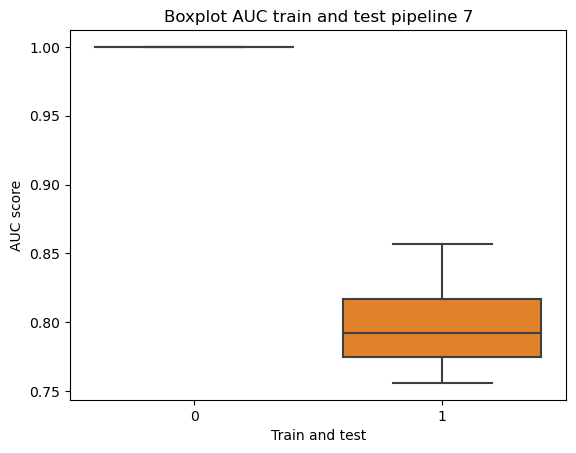

In [ ]:
# PIPELINE 7

# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

auc_design_7 = []
auc_test_7 = []

best_auc_design_7 = []
best_auc_test_7 = []

results_7 = pd.DataFrame()
best_pipe_7 = []
best_hp_7a = pd.DataFrame()
best_hp_7 = pd.DataFrame()

y_test_7_all = []
y_pred_7_all = []

for design_index, test_index in outer_cv.split(X, y): 
    X_design = X.transpose()[design_index]
    X_design = X_design.transpose()
    print(f'Size_X_design {X_design.shape}') # print size of X_design
    y_design = y[design_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_7 = y[test_index]
    y_test_7_all.append(y_test_7)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_design = missing_data(X_design)
    # X_test = missing_data(X_test)
    # remove outliers
    X_design = removing_outliers(X_design)
    X_test = removing_outliers(X_test)

    # balance the classes, so design set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_design, y_design)
    X_design = X_resampled
    y_design = y_resampled   

    print(f'shape after balancing {X_design.shape}')  

    # Scaling the data
    scaler = RobustScaler()
    X_design = scaler.fit_transform(X_design)
    X_test = scaler.transform(X_test)

    ## PIPELINE 7: RobustScaler --> LASSO --> RF
    # Define pipeline 7
    pipeline_7a = Pipeline([
        ('lasso', Lasso()),
    ])
    # Define hyperparameters of pipeline 5
    param_grid_7a = {
    'lasso__alpha': np.logspace(-10, 1, 100),
    }

    # Perform randomized search with inner cross-validation to find best alpha
    rand_search_7a = RandomizedSearchCV(pipeline_7a, param_distributions=param_grid_7a, n_iter =50, cv=inner_cv, scoring='f1',n_jobs=-1) # optimize parameters
    rand_search_7a.fit(X_design, y_design)
    
    # Create a new Lasso model using the best alpha value
    lasso = Lasso(alpha=rand_search_7a.best_params_['lasso__alpha'])
    lasso.fit(X_design, y_design)

    # Get the coefficients of the Lasso model, find them and define the new X_design with less features
    coef = lasso.coef_
    selected_features = np.where(coef != 0)[0]
    X_design = X_design[:, selected_features]
    X_test = X_test[:, selected_features]
    print(f'This is the size of X_design after LASSO: {X_design.shape}')

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_7a = best_hp_7a.append(rand_search_7a.best_params_,ignore_index=True)
    
    print(f'This is the size of X_design after LASSO: {X_design.shape}')

## PIPELINE 7: RF
    # Define pipeline 7b
    pipeline_7b = Pipeline([
        ('clf', RandomForestClassifier())])
    
    # Define scores BEFORE hyperparameter tuning
    pipeline_7b.fit(X_design, y_design)
 
    y_pred_design_7 = pipeline_7b.predict_proba(X_design)[:,1]
    f1_design_7 = f1_score(y_design, y_pred_design_7)

    y_pred_test_7 = pipeline_7b.predict_proba(X_test)[:,1]
    f1_test_7 = f1_score(y_test_7, y_pred_test_7)

    auc_design_7.append(f1_design_7)
    auc_test_7.append(f1_test_7)

    # Define hyperparameters of pipeline 7b
    param_grid_7b = {'clf__n_estimators' : range(2,6),
                               'clf__criterion' :['gini','entropy','log_loss'],
                               'clf__min_samples_split':range(2,10),
                               'clf__min_samples_leaf':range(1,10),
                               'clf__min_weight_fraction_leaf' : np.linspace(0, 0.5, 25),
                               'clf__max_features':['sqrt','log2',None],
                               'clf__bootstrap':[True,False],
                               'clf__warm_start':[True,False],
                               }

    # Perform grid search with inner cross-validation, part 1
    model_7 = RandomizedSearchCV(pipeline_7b, param_distributions=param_grid_7b, n_iter=50, cv=inner_cv, scoring='f1', n_jobs=-1) # optimize parameters
    model_7.fit(X_design, y_design)

    # Storing results cross-validation
    results = pd.DataFrame(model_7.cv_results_)
    results_7 = results_7.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_design_7 = model_7.predict_proba(X_design)[:,1]
    best_f1_score_design_7 = f1_score(y_design, best_y_pred_design_7)

    best_y_pred_test_7 = model_7.predict_proba(X_test)[:,1]
    best_f1_score_test_7 = f1_score(y_test_7, best_y_pred_test_7)

    best_auc_design_7.append(best_f1_score_design_7)
    best_auc_test_7.append(best_f1_score_test_7)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_7.append(model_7.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_7a}')
print(f'The optimal hyperparameters per split: {best_hp_7}')
print(f'The best pipes per split {best_pipe_7}')

print(f'The design AUCs before tuning {auc_design_7}')
print(f'The test AUCs before tuning {auc_test_7}')

print(f'The design AUCs after tuning {best_auc_design_7}')
print(f'The test AUCs afer tuning {best_auc_test_7}')

data_7 = [best_auc_design_7, best_auc_test_7]
sns.boxplot(data=data_7)
plt.title('Boxplot AUC design and test pipeline 7')
plt.xlabel('design and test')
plt.ylabel('AUC score')
plt.show()   


## Ouput visualization
- Tabel ROC/AUC
- Plot ROC/AUC
- Confusion matrix
- Tabel chosen hyperparameters

In [ ]:
# Tabel ROC-AUC
from IPython.display import HTML

# create the DataFrame
df = pd.DataFrame({
    'Pipeline 1': best_auc_test_1,
    #'Pipeline 2': best_auc_test_2,
    'Pipeline 3': best_auc_test_3,
    'Pipeline 4': best_auc_test_4,
    'Pipeline 5': best_auc_test_5,
    #'Pipeline 6': best_auc_test_6,
    'Pipeline 7': best_auc_test_7
})

# define a function to format the table
def format_table(df):
    return df.style.set_table_styles([{
        'selector': 'th',
        'props': [
            ('font-size', '14pt'),
            ('text-align', 'center'),
            ('border', '1px solid #ddd'),
            ('padding', '8px')
        ]
    }, {
        'selector': 'td',
        'props': [
            ('font-size', '12pt'),
            ('text-align', 'center'),
            ('border', '1px solid #ddd'),
            ('padding', '8px')
        ]
    }])

# display the DataFrame as a table
print('Table ROC-AUC')
HTML(format_table(df).render())

Table ROC-AUC


C:\Users\irisv\AppData\Local\Temp\ipykernel_9384\2490066542.py:37: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  HTML(format_table(df).render())


,Pipeline 1,Pipeline 3,Pipeline 4,Pipeline 5,Pipeline 7
0,0.500000,0.500000,0.409091,0.750000,0.500000
1,0.666667,0.666667,0.566667,0.566667,0.500000
2,0.900000,0.450000,0.500000,0.750000,0.500000
3,0.700000,0.650000,0.650000,0.400000,0.700000


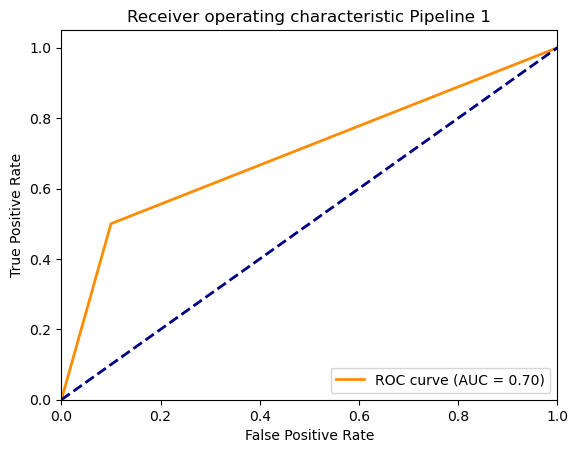

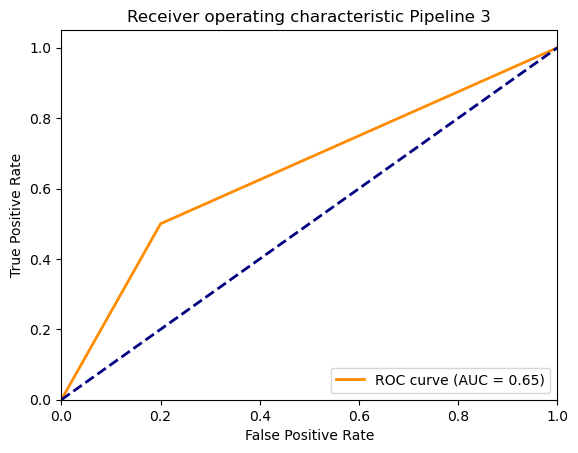

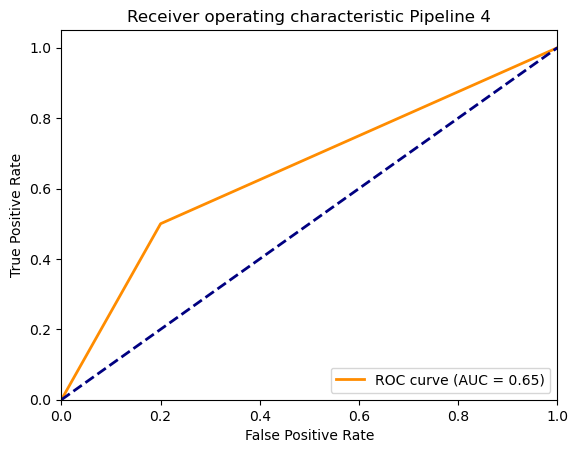

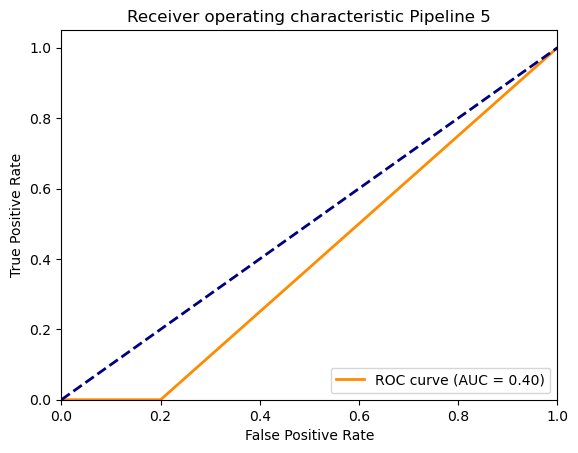

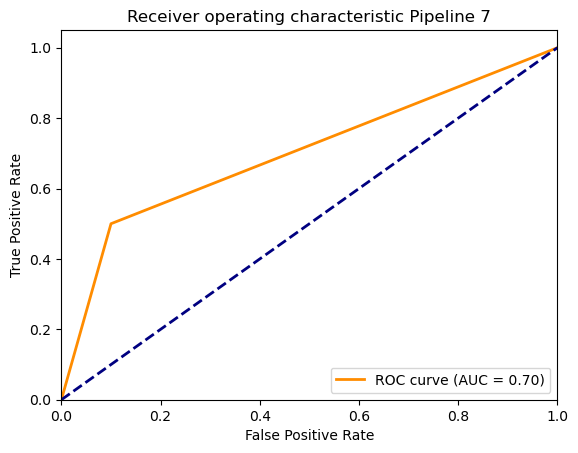

In [ ]:
# Plot ROC-AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# y_test contains the true labels, y_pred contains the predicted scores
fpr1, tpr1, thresholds = roc_curve(y_test_1_all, y_pred_1_all)

# Calculate the area under the curve (AUC)
f1_1 = auc(fpr1, tpr1)

# Plot the ROC curve
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % f1_1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 1')
plt.legend(loc="lower right")
plt.show()

# # y_test contains the true labels, y_pred contains the predicted scores
# fpr2, tpr2, thresholds = roc_curve(y_test_2_all, y_pred_2_all)

# # Calculate the area under the curve (AUC)
# f1_2 = auc(fpr2, tpr2)

# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % f1_2)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic Pipeline 2')
# plt.legend(loc="lower right")
# plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr3, tpr3, thresholds = roc_curve(y_test_3_all, y_pred_3_all)

# Calculate the area under the curve (AUC)
f1_3 = auc(fpr3, tpr3)

# Plot the ROC curve
plt.figure()
plt.plot(fpr3, tpr3, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % f1_3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 3')
plt.legend(loc="lower right")
plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr4, tpr4, thresholds = roc_curve(y_test_4_all, y_pred_4_all)

# Calculate the area under the curve (AUC)
f1_4 = auc(fpr4, tpr4)

# Plot the ROC curve
plt.figure()
plt.plot(fpr4, tpr4, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % f1_4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 4')
plt.legend(loc="lower right")
plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr5, tpr5, thresholds = roc_curve(y_test_5_all, y_pred_5_all)

# Calculate the area under the curve (AUC)
f1_5 = auc(fpr5, tpr5)

# Plot the ROC curve
plt.figure()
plt.plot(fpr5, tpr5, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % f1_5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 5')
plt.legend(loc="lower right")
plt.show()

# # y_test contains the true labels, y_pred contains the predicted scores
# fpr6, tpr6, thresholds = roc_curve(y_test_6_all, y_pred_6_all)

# # Calculate the area under the curve (AUC)
# f1_6 = auc(fpr6, tpr6)

# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr6, tpr6, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % f1_6)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic Pipeline 6')
# plt.legend(loc="lower right")
# plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr7, tpr7, thresholds = roc_curve(y_test_7_all, y_pred_7_all)

# Calculate the area under the curve (AUC)
f1_7 = auc(fpr7, tpr7)

# Plot the ROC curve
plt.figure()
plt.plot(fpr7, tpr7, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % f1_7)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 7')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_pred_1_all_df = pd.DataFrame(y_pred_1_all)
y_pred_1_all_split = pd.DataFrame()
for row in y_pred_1_all_df.index:
    gezeik = pd.DataFrame(y_pred_1_all[row]).transpose()
    y_pred_1_all_split = pd.concat([y_pred_1_all_split, gezeik], ignore_index=True)

# print(y_pred_1_all_split)

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_1_all_bin = y_pred_1_all_split.apply(lambda x: np.where(x >= 0.5, 1, 0))
print(y_pred_1_all_bin.shape)
# y_test contains the true labels, y_pred contains the predicted labels
cm1 = confusion_matrix(y_test_1_all, y_pred_1_all_bin)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm1, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 1')
plt.show()

(10, 83)


TypeError: function takes exactly 0 arguments (1 given)

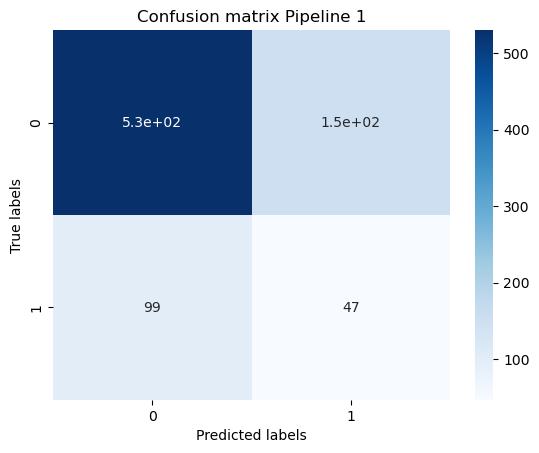

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

threshold = 0.5
cm_all = None

for i in range(len(y_pred_1_all)):
    y_pred_1_all_bin= np.array(y_pred_1_all[i])
    y_pred_1_all_bin = np.where(y_pred_1_all_bin >= threshold, 1, 0)

    cm_i = confusion_matrix(y_test_1_all[i], y_pred_1_all_bin)

    if cm_all is None:
        cm_all = cm_i
    else:
        cm_all += cm_i

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_all, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 1')
plt.show()

# # # y_test contains the true labels, y_pred contains the predicted labels
# # cm2 = confusion_matrix(y_test_2_all, y_pred_2_all)

# # # Plot the confusion matrix as a heatmap
# # sns.heatmap(cm2, annot=True, cmap='Blues')
# # plt.xlabel('Predicted labels')
# # plt.ylabel('True labels')
# # plt.title('Confusion matrix Pipeline 2')
# # plt.show()

# # y_test contains the true labels, y_pred contains the predicted labels
# cm3 = confusion_matrix(y_test_3_all, y_pred_3_all)

# # Plot the confusion matrix as a heatmap
# sns.heatmap(cm3, annot=True, cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion matrix Pipeline 3')
# plt.show()

# # y_test contains the true labels, y_pred contains the predicted labels
# cm4 = confusion_matrix(y_test_4_all, y_pred_4_all)

# # Plot the confusion matrix as a heatmap
# sns.heatmap(cm4, annot=True, cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion matrix Pipeline 4')
# plt.show()

# # y_test contains the true labels, y_pred contains the predicted labels
# cm5 = confusion_matrix(y_test_5_all, y_pred_5_all)

# # Plot the confusion matrix as a heatmap
# sns.heatmap(cm5, annot=True, cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion matrix Pipeline 5')
# plt.show()

# # # y_test contains the true labels, y_pred contains the predicted labels
# # cm6 = confusion_matrix(y_test_6_all, y_pred_6_all)

# # # Plot the confusion matrix as a heatmap
# # sns.heatmap(cm6, annot=True, cmap='Blues')
# # plt.xlabel('Predicted labels')
# # plt.ylabel('True labels')
# # plt.title('Confusion matrix Pipeline 6')
# # plt.show()

# # y_test contains the true labels, y_pred contains the predicted labels
# cm7 = confusion_matrix(y_test_7_all, y_pred_7_all)

# # Plot the confusion matrix as a heatmap
# sns.heatmap(cm7, annot=True, cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion matrix Pipeline 7')
# plt.show()

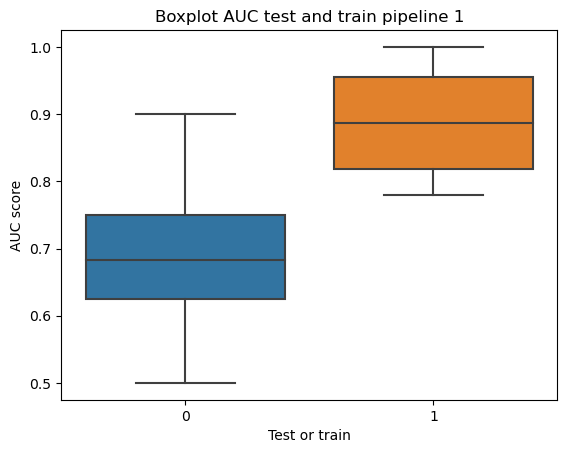

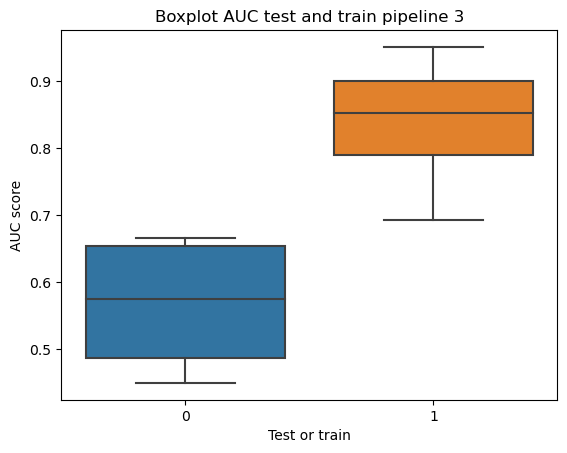

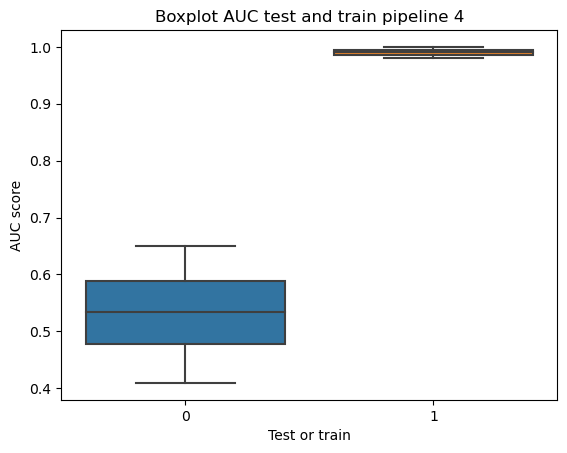

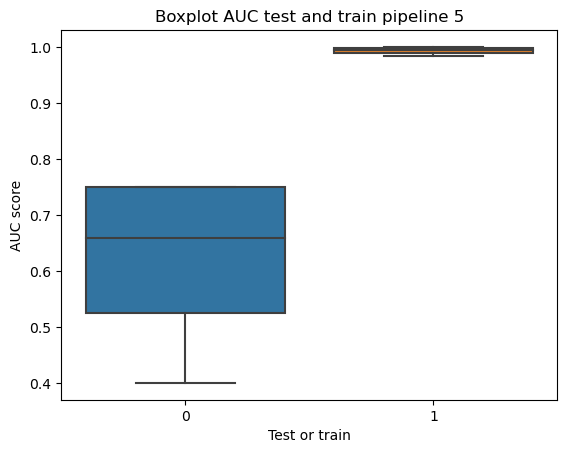

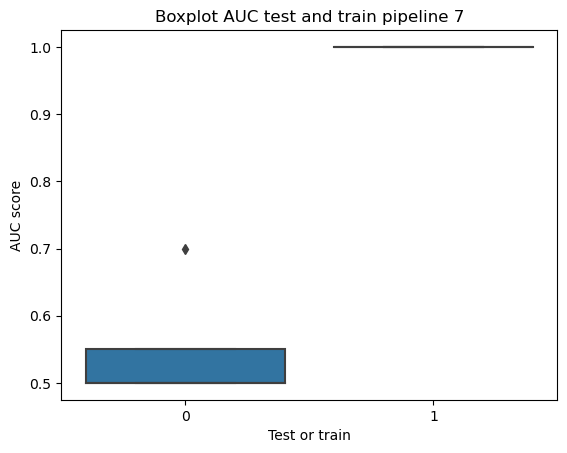

In [ ]:
# Boxplots
data_1 = [best_auc_test_1, best_auc_design_1]
sns.boxplot(data=data_1)
plt.title('Boxplot AUC test and design pipeline 1')
plt.xlabel('Test or design')
plt.ylabel('AUC score')
plt.show()
data_2 = [best_auc_test_2, best_auc_design_2]
sns.boxplot(data=data_2)
plt.title('Boxplot AUC test and design pipeline 2')
plt.xlabel('Test or design')
plt.ylabel('AUC score')
plt.show()
data_3 = [best_auc_test_3, best_auc_design_3]
sns.boxplot(data=data_3)
plt.title('Boxplot AUC test and design pipeline 3')
plt.xlabel('Test or design')
plt.ylabel('AUC score')
plt.show()
data_4 = [best_auc_test_4, best_auc_design_4]
sns.boxplot(data=data_4)
plt.title('Boxplot AUC test and design pipeline 4')
plt.xlabel('Test or design')
plt.ylabel('AUC score')
plt.show()
data_5 = [best_auc_test_5, best_auc_design_5]
sns.boxplot(data=data_5)
plt.title('Boxplot AUC test and design pipeline 5')
plt.xlabel('Test or design')
plt.ylabel('AUC score')
plt.show()
data_6 = [best_auc_test_6, best_auc_design_6]
sns.boxplot(data=data_6)
plt.title('Boxplot AUC test and design pipeline 6')
plt.xlabel('Test or design')
plt.ylabel('AUC score')
plt.show()
data_7 = [best_auc_test_7, best_auc_design_7]
sns.boxplot(data=data_7)
plt.title('Boxplot AUC test and design pipeline 7')
plt.xlabel('Test or design')
plt.ylabel('AUC score')
plt.show()


In [ ]:
# # Tabel hyperparameter chosen one
# # Tabel ROC-AUC
# from IPython.display import HTML

# # Hierboven hyperparameters van de gekozen invullen
# df = pd.DataFrame({'Hyperparameter 1': best_hp_1                   
# })

# # define a function to format the table
# def format_table(df):
#     return df.style.set_table_styles([{
#         'selector': 'th',
#         'props': [
#             ('font-size', '14pt'),
#             ('text-align', 'center'),
#             ('border', '1px solid #ddd'),
#             ('padding', '8px')
#         ]
#     }, {
#         'selector': 'td',
#         'props': [
#             ('font-size', '12pt'),
#             ('text-align', 'center'),
#             ('border', '1px solid #ddd'),
#             ('padding', '8px')
#         ]
#     }])

# # display the DataFrame as a table
# print('Table Hyperparameters')
# HTML(format_table(df).render())